# Game classification network


#### view frame

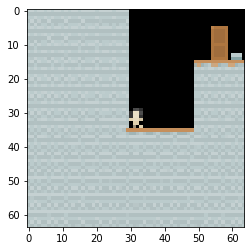

In [1]:
from PIL import Image
from matplotlib import pyplot as plt
from utils import make_env, Storage, orthogonal_init

env = make_env(1, num_levels=1,env_name='coinrun')
ob = env.reset()
img = ob[0].permute(1,2,0).numpy()
plt.imshow(img)

## Generate images

In [2]:
import argparse
import sys
from utils import make_env, Storage, orthogonal_init
import gym
import os
import numpy as np
from gym import wrappers, logger
from PIL import Image
import pickle as pkl
from matplotlib import pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch

class RandomAgent(object):
    """The world's simplest agent!"""
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done):
        return self.action_space.sample()
    
num_envs = 1
num_steps = 256
num_levels = 100
env_names = ['bigfish', 'bossfight', 'caveflyer', 'chaser', 'climber', 'coinrun', 'dodgeball', 'fruitbot', 'heist', 'jumper', 'leaper', 'maze', 'miner', 'ninja', 'plunder', 'starpilot',]

In [3]:
episode_count = 5
labels = np.empty(num_steps*len(env_names)*episode_count)
data = np.empty((num_steps*len(env_names)*episode_count,3,64,64))
counter = -1
for j,env_name in enumerate(env_names):
    print(f"doing {env_name}")
    env = make_env(num_envs, num_levels=num_levels,env_name=env_name)

    agent = RandomAgent(env.action_space)

    
    reward = 0
    done = False
    ob = env.reset()
    for i in range(episode_count):
        for step in range(num_steps):
            action = np.array([agent.act(ob, reward, done)])
            ob, reward, done, _ = env.step(action)
            img = ob.numpy()
            counter += 1
            data[counter] = img
            labels[counter] = j
            if done:
                break
    env.close()
data = data[0:counter-1]
labels = labels[0:counter-1]
print(data.shape)
with open('data.pkl','wb') as f:
    pkl.dump(data,f)
with open('datalabels.pkl','wb') as f:
    pkl.dump(labels,f)

doing bigfish
doing bossfight
doing caveflyer
doing chaser
doing climber
doing coinrun
doing dodgeball
doing fruitbot
doing heist
doing jumper
doing leaper
doing maze
doing miner
doing ninja
doing plunder
doing starpilot
(13222, 3, 64, 64)


In [20]:
with open('data.pkl','rb') as f:
    data = pkl.load(f)
with open('datalabels.pkl','rb') as f:
    labels = pkl.load(f)

## Setup training and test sets

In [21]:
# CUDA for PyTorch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
max_epochs = 5
batch_size = 6
# Datasets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
# Generators
training_set = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
trainloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size,shuffle=True, num_workers=2)

validation_set = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
testloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size,shuffle=True, num_workers=2)

print("# Training data")
print("Number of points:", len(training_set))
print("# Validation data")
print("Number of points:", len(validation_set))


# Training data
Number of points: 10577
# Validation data
Number of points: 2645


### Define CNN

In [22]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, input_channels, input_height, input_width, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        
        self.conv_1 = nn.Conv2d(in_channels=input_channels,
                            out_channels=32,
                            kernel_size=5, 
                            padding=2)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, 
                            out_channels=64,
                            kernel_size=5, 
                            padding=2)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        self.conv2_drop = nn.Dropout2d()

        self.dense_features = 64 * input_height//2 * input_width//2
        self.dense = nn.Linear(in_features=self.dense_features, 
                                out_features=50,
                                bias=True)
        self.dropout = nn.Dropout(p=0.5)
        
        self.dense_out = nn.Linear(in_features=50,
                             out_features=num_classes,
                                bias=False)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = self.batchnorm1(x)
        x = F.relu(self.conv_2(x))
        x = self.batchnorm2(x)
        x = self.maxpool(x)

        x = self.conv2_drop(x)
        x = x.view(-1, self.dense_features)
        x = F.relu(self.dense(x))

        return F.log_softmax(self.dense_out(x), dim=1)
    
X_train, X_test, y_train, y_test
net = Net(3,64,64,len(env_names))
if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()
print(net)

##converting network to cuda-enabled
Net(
  (conv_1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (dense): Linear(in_features=65536, out_features=50, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (dense_out): Linear(in_features=50, out_features=16, bias=False)
)


In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), momentum=0.8, lr=0.001)

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if torch.cuda.is_available():
        return x.cuda()
    return x

### Training loop

In [24]:
# Loop over epochs
for epoch in range(max_epochs):
    # Training
    running_loss = 0.0
    i = 0
    for inputs, labels in trainloader:
        # Transfer to GPU
        labels = labels.long()
        inputs, labels = get_variable(Variable(inputs)), get_variable(Variable(labels))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()


        # print statistics
        running_loss += loss.data.item()
        if i % 100 == 99:    # print every 1000 mini-batches
            print('[%d, %5d] train loss: %.4f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        i += 1

[1,   100] train loss: 0.6470
[1,   200] train loss: 0.3010
[1,   300] train loss: 0.1317
[1,   400] train loss: 0.0994
[1,   500] train loss: 0.0652
[1,   600] train loss: 0.0620
[1,   700] train loss: 0.0784
[1,   800] train loss: 0.0515
[1,   900] train loss: 0.0337
[1,  1000] train loss: 0.0246
[1,  1100] train loss: 0.0170
[1,  1200] train loss: 0.0158
[1,  1300] train loss: 0.0237
[1,  1400] train loss: 0.0179
[1,  1500] train loss: 0.0148
[1,  1600] train loss: 0.0102
[1,  1700] train loss: 0.0168
[2,   100] train loss: 0.0076
[2,   200] train loss: 0.0035
[2,   300] train loss: 0.0067
[2,   400] train loss: 0.0021
[2,   500] train loss: 0.0020
[2,   600] train loss: 0.0040
[2,   700] train loss: 0.0019
[2,   800] train loss: 0.0102
[2,   900] train loss: 0.0045
[2,  1000] train loss: 0.0027
[2,  1100] train loss: 0.0044
[2,  1200] train loss: 0.0071
[2,  1300] train loss: 0.0030
[2,  1400] train loss: 0.0012
[2,  1500] train loss: 0.0023
[2,  1600] train loss: 0.0014
[2,  1700]

### Analyze training results

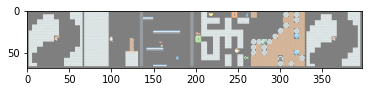

GroundTruth:   caveflyer coinrun climber heist miner caveflyer
Predicted:     caveflyer coinrun climber heist miner caveflyer


In [25]:
images, labels = iter(testloader).next()
labels = labels.int()
def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % env_names[labels[j]] for j in range(batch_size)))

outputs = net(get_variable(images))
_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % env_names[predicted[j]] for j in range(batch_size)))

In [26]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(get_variable(Variable(images)))
    _, predicted = torch.max(outputs.cpu().data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    len(validation_set), 100 * correct.true_divide(total)))

Accuracy of the network on the 2645 test images: 99.92 %
